# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

##Imports

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common use
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import keras
import cv2

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

tf.version: 2.8.2
keras.version: 2.8.0


##Load data

In [39]:
# import images and get a list with its paths
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/data/manual-images'
file_list = []
for root, dir, files in os.walk(data_dir):
  for name in files:
    file_list.append(os.path.join(root,name))
image_paths = [i for i in file_list if i[-4:] == '.png'] # we only want files with .png extension

steering_angles = [int(name[-7:-4]) for name in image_paths]

print('number of images: %d' % len(image_paths))
print('number of steering angles: %d' % len(steering_angles))

number of images: 1841


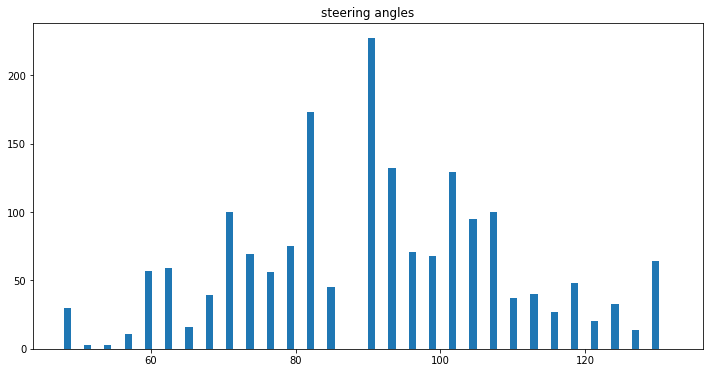

In [40]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(12,6))
plt.hist(steering_angles, bins=30, width=1)
plt.title('steering angles')
plt.show()

# Prepare data

In [41]:
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    labels=steering_angles, 
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(240,320),
    seed=123)

train_dataset = full_dataset.take(int(len(full_dataset)*0.8))
test_dataset = full_dataset.skip(int(len(full_dataset)*0.8))

Found 1841 files belonging to 3 classes.


In [42]:
print(len(full_dataset))
print(len(test_dataset))
print(len(train_dataset))

58
12
46


# Visualize data

(240, 320, 3)


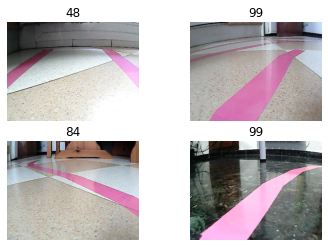

In [50]:
def show_images(dataset):
  images = []
  while len(images) < 4:
    for images, labels in dataset.take(1):
      im_shape = images[1].shape
      for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(labels[i].numpy())
        plt.axis('off')
  print(images[1].shape)

show_images(train_dataset)

(240, 320, 3)


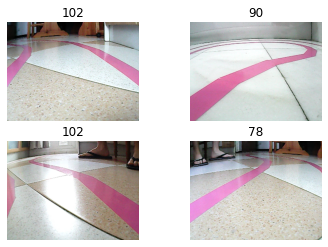

In [51]:
show_images(test_dataset)

# Regression head

In [33]:
model = tf.keras.Sequential([
  # preprocessing
  tf.keras.layers.Cropping2D(cropping=((120,0),(0,0))),
  tf.keras.layers.Resizing(66,200),
  #tf.keras.layers.RandomRotation(0.01),
  tf.keras.layers.Rescaling(1./255),
  
  # conv layers
  keras.layers.Conv2D(24, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(36, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(48, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(64, 3, activation='elu'), 
  keras.layers.Conv2D(64, 3, activation='elu'), 

  # fully connected layers
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(100, activation='elu'),
  tf.keras.layers.Dense(50, activation='elu'),
  tf.keras.layers.Dense(10, activation='elu'),
  #tf.keras.layers.GlobalAveragePooling2D(),
  
  # output layer
  keras.layers.Dense(1),
])

In [ ]:
'''model = tf.keras.Sequential([
  # preprocessing
  tf.keras.layers.Cropping2D(cropping=((80,0),(0,0))),
  tf.keras.layers.Resizing(61,157),
  tf.keras.layers.RandomRotation(0.01),
  tf.keras.layers.Rescaling(1./255),
  
  # conv layers
  keras.layers.Conv2D(24, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(36, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(48, 5, strides=2, activation='elu'),
  keras.layers.Conv2D(64, 3, activation='elu'), 
  keras.layers.Conv2D(64, 3, activation='elu'), 

  # fully connected layers
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(100, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='elu'),
  tf.keras.layers.Dropout(0.1),
  #tf.keras.layers.GlobalAveragePooling2D(),
  
  # output layer
  keras.layers.Dense(1),
])'''

"model = tf.keras.Sequential([\n  # preprocessing\n  tf.keras.layers.Cropping2D(cropping=((80,0),(0,0))),\n  tf.keras.layers.Resizing(61,157),\n  tf.keras.layers.RandomRotation(0.01),\n  tf.keras.layers.Rescaling(1./255),\n  \n  # conv layers\n  keras.layers.Conv2D(24, 5, strides=2, activation='elu'),\n  keras.layers.Conv2D(36, 5, strides=2, activation='elu'),\n  keras.layers.Conv2D(48, 5, strides=2, activation='elu'),\n  keras.layers.Conv2D(64, 3, activation='elu'), \n  keras.layers.Conv2D(64, 3, activation='elu'), \n\n  # fully connected layers\n  tf.keras.layers.Flatten(),\n\n  tf.keras.layers.Dense(100, activation='elu'),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(50, activation='elu'),\n  tf.keras.layers.Dropout(0.2),\n  tf.keras.layers.Dense(10, activation='elu'),\n  tf.keras.layers.Dropout(0.1),\n  #tf.keras.layers.GlobalAveragePooling2D(),\n  \n  # output layer\n  keras.layers.Dense(1),\n])"

# Configure model

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', 
              optimizer=opt)

In [36]:
model.build((32,240,320,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_1 (Cropping2D)   (32, 160, 320, 3)         0         
                                                                 
 resizing_1 (Resizing)       (32, 66, 200, 3)          0         
                                                                 
 rescaling_1 (Rescaling)     (32, 66, 200, 3)          0         
                                                                 
 conv2d_5 (Conv2D)           (32, 31, 98, 24)          1824      
                                                                 
 conv2d_6 (Conv2D)           (32, 14, 47, 36)          21636     
                                                                 
 conv2d_7 (Conv2D)           (32, 5, 22, 48)           43248     
                                                                 
 conv2d_8 (Conv2D)           (32, 3, 20, 64)          

# Training

In [37]:
model_output_dir = '/content/drive/My Drive/Colab Notebooks/Autonomous Car/model'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'autonomous_car_v4_check.h5'), verbose=1, save_best_only=True)

history = model.fit(train_dataset,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint_callback],
                    validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 1479.6812
Epoch 1: val_loss improved from inf to 888.93970, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_v4_check.h5
98/98 [==============================] - 51s 507ms/step - loss: 1479.6812 - val_loss: 888.9397
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 955.1239
Epoch 2: val_loss improved from 888.93970 to 878.15369, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_v4_check.h5
98/98 [==============================] - 48s 481ms/step - loss: 955.1239 - val_loss: 878.1537
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 915.7719
Epoch 3: val_loss improved from 878.15369 to 857.40356, saving model to /content/drive/My Drive/Colab Notebooks/Autonomous Car/model/autonomous_car_v4_check.h5
98/98 [==============================] - 48s 479ms/step - loss: 915.7719 - val_loss: 857.4036
Epoch 4/10


KeyboardInterrupt: ignored

## Save model

In [ ]:
model.save(os.path.join(model_output_dir,'autonomous_car_v4.h5'))

# Print accuracy

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.plot(loss[:10], label='Training Loss')
ax.plot(val_loss[:10], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.title('MobileNet V2')
plt.xlabel('epoch',labelpad=2)
ax.yaxis.tick_right()
plt.show()